Dang! After 2020-05-21, WindSpeed is accidentally in feet/second, not meters/second. Also, workers didn't record Rainfall if there was no rain. You’re also interested in the effect of Weekday and Month


In [1]:
import pandas as pd
df = pd.read_csv("dataPotholes.csv")
df

,Date,PotholeReports,Temperature,Humidity,WindSpeed,Rainfall,ExpectedWorkload
0,2019-11-21,254,65.2,37,2.200000,NaN,Low
1,2019-11-21,204,65.5,38,0.800000,NaN,Low
2,2019-11-21,173,66.0,39,1.000000,NaN,Low
3,2019-11-21,107,66.2,40,0.900000,NaN,Low
4,2019-11-21,78,66.0,36,2.300000,NaN,Low
...,...,...,...,...,...,...,...
8755,2020-11-19,1003,55.8,34,8.530184,NaN,Low
8756,2020-11-19,764,56.6,37,7.545932,NaN,Low
8757,2020-11-19,694,57.4,39,0.984252,NaN,Low
8758,2020-11-19,712,57.9,41,3.280840,NaN,Low


In [2]:
df["Date"] = pd.to_datetime(df["Date"])

In [3]:
df["WindSpeed2"] = df["WindSpeed"].copy()

In [4]:
df.loc[df["Date"] > "2020-05-21", "WindSpeed2"] = df["WindSpeed2"] / 3.281

In [5]:
df["Rainfall2"] = df["Rainfall"].copy()

In [6]:
df.loc[df["Rainfall2"].isna(), "Rainfall2"] = 0
# df["Rainfall2"] = df["Rainfall2"].fillna(0) also works

In [7]:
df["Weekday"] = df["Date"].dt.day_name()

In [8]:
df["Month"] = df["Date"].dt.month_name()

Predict PotholeReports using inferential models (w/o ExpectedWorkload and Date)
* How strong is the model?
*  Is there anything that’s not significant
*  Interpret at least 2 significant variables.


In [9]:
import statsmodels.formula.api as smf

In [10]:
mod1 = smf.ols("PotholeReports ~ Temperature + Humidity + WindSpeed2 + Rainfall2 +\
                 Weekday + Month", data = df).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:         PotholeReports   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     317.9
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:50:56   Log-Likelihood:                -66614.
No. Observations:                8760   AIC:                         1.333e+05
Df Residuals:                    8738   BIC:                         1.334e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2729.4398 

* How strong is the model?
    - 43.3% of the variability in pothole reports is explained by the model
* Is there anything that’s not significant?
    - The categories, Monday and December, are not significant at the 0.05 level
* Interpret at least 2 significant variables.
    - If it's a Sunday, there are predicted to be 39.8 more pothole reports than if it's a Friday, holding other variables constant
    - If it's August, there are predicted to be 152.2 fewer pothole reports than if it's April, holding other variables constant
    - For each 1 degree increase in temperature, pothole reports are predicted to decrease by 34, holding other variables constant

When looking at the scatter matrix, you can see that PotholeReports is heavily skewed and it's also a counted variable. Therefore, a poisson regression is more appropriate.

array([[<Axes: xlabel='PotholeReports', ylabel='PotholeReports'>,
        <Axes: xlabel='Temperature', ylabel='PotholeReports'>,
        <Axes: xlabel='Humidity', ylabel='PotholeReports'>,
        <Axes: xlabel='WindSpeed', ylabel='PotholeReports'>,
        <Axes: xlabel='Rainfall', ylabel='PotholeReports'>,
        <Axes: xlabel='WindSpeed2', ylabel='PotholeReports'>,
        <Axes: xlabel='Rainfall2', ylabel='PotholeReports'>],
       [<Axes: xlabel='PotholeReports', ylabel='Temperature'>,
        <Axes: xlabel='Temperature', ylabel='Temperature'>,
        <Axes: xlabel='Humidity', ylabel='Temperature'>,
        <Axes: xlabel='WindSpeed', ylabel='Temperature'>,
        <Axes: xlabel='Rainfall', ylabel='Temperature'>,
        <Axes: xlabel='WindSpeed2', ylabel='Temperature'>,
        <Axes: xlabel='Rainfall2', ylabel='Temperature'>],
       [<Axes: xlabel='PotholeReports', ylabel='Humidity'>,
        <Axes: xlabel='Temperature', ylabel='Humidity'>,
        <Axes: xlabel='Humidity', yl

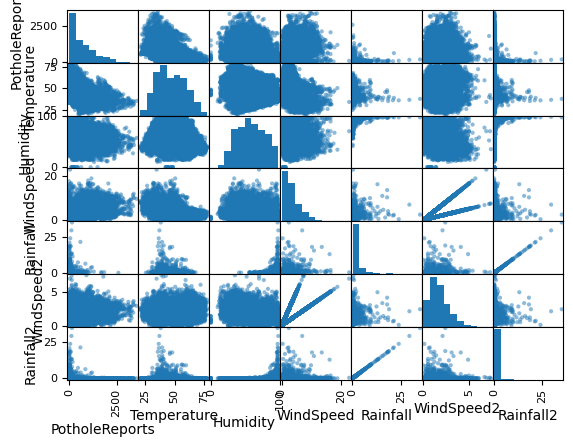

In [11]:
pd.plotting.scatter_matrix(df)

In [12]:
mod2 = smf.poisson("PotholeReports ~ Temperature + Humidity + WindSpeed2 + Rainfall2 +\
                 Weekday + Month", data = df).fit()
print(mod2.summary())

Optimization terminated successfully.
         Current function value: 147.920779
         Iterations 8
                          Poisson Regression Results                          
Dep. Variable:         PotholeReports   No. Observations:                 8760
Model:                        Poisson   Df Residuals:                     8738
Method:                           MLE   Df Model:                           21
Date:                Thu, 25 Apr 2024   Pseudo R-squ.:                  0.4864
Time:                        01:51:01   Log-Likelihood:            -1.2958e+06
converged:                       True   LL-Null:                   -2.5232e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.0711      0.005   1934.658      0.000       9.062       9.0

In [13]:
print(mod2.get_margeff().summary())

       Poisson Marginal Effects      
Dep. Variable:         PotholeReports
Method:                          dydx
At:                           overall
                          dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Weekday[T.Monday]        6.0775      1.071      5.673      0.000       3.978       8.177
Weekday[T.Saturday]    -59.2561      1.097    -54.039      0.000     -61.405     -57.107
Weekday[T.Sunday]       53.6630      1.055     50.887      0.000      51.596      55.730
Weekday[T.Thursday]     63.3168      1.043     60.733      0.000      61.273      65.360
Weekday[T.Tuesday]      47.2153      1.056     44.713      0.000      45.146      49.285
Weekday[T.Wednesday]    39.7287      1.073     37.027      0.000      37.626      41.832
Month[T.August]       -159.5496      1.493   -106.866      0.000    -162.476    -156.623
Month[T.December]     -374.6832      2.355   -1

Remember that, for a poisson or logit regression, you should interpret the marginal effects and not the summary coefficients.

Predict ExpectedWorkload using an ML Classifier (w/o PotholeReports and Date)
* Partition 33% for the test data and use a random_state of 42
* Do you have any concerns about your model's predictive performance?

In [14]:
outcome = df["ExpectedWorkload"]

In [15]:
numericFeatures = df[["Temperature", "Humidity", "WindSpeed2", "Rainfall2"]]

In [16]:
dummies = pd.get_dummies(df[["Weekday", "Month"]], drop_first = True)

In [17]:
features = pd.concat([numericFeatures, dummies], axis = 1)
features

,Temperature,Humidity,WindSpeed2,Rainfall2,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,65.2,37,2.200000,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,65.5,38,0.800000,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,66.0,39,1.000000,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,66.2,40,0.900000,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,66.0,36,2.300000,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,55.8,34,2.599873,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
8756,56.6,37,2.299888,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
8757,57.4,39,0.299985,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
8758,57.9,41,0.999951,0.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [18]:
from sklearn.model_selection import train_test_split
featuresTrain, featuresTest, outcomeTrain, outcomeTest = train_test_split(features, outcome,
                                                                         test_size = 0.33,
                                                                         random_state = 42)

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       176
         Low       1.00      1.00      1.00      4492
      Medium       1.00      1.00      1.00      1201

    accuracy                           1.00      5869
   macro avg       1.00      1.00      1.00      5869
weighted avg       1.00      1.00      1.00      5869

              precision    recall  f1-score   support

        High       0.15      0.15      0.15        92
         Low       0.84      0.83      0.84      2227
      Medium       0.36      0.37      0.36       572

    accuracy                           0.72      2891
   macro avg       0.45      0.45      0.45      2891
weighted avg       0.72      0.72      0.72      2891



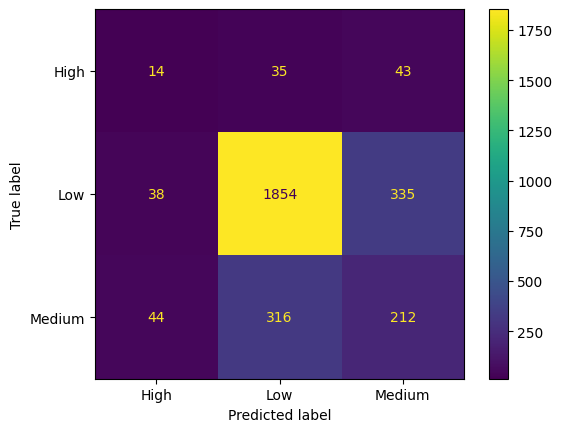

In [19]:
import sklearn.tree
modTree = sklearn.tree.DecisionTreeClassifier(random_state = 42)
modTree.fit(featuresTrain, outcomeTrain)
predTreeTrain = modTree.predict(featuresTrain)
predTreeTest = modTree.predict(featuresTest)
print(sklearn.metrics.classification_report(outcomeTrain, predTreeTrain))
print(sklearn.metrics.classification_report(outcomeTest, predTreeTest))
cmTreeTest = sklearn.metrics.confusion_matrix(outcomeTest, predTreeTest)
sklearn.metrics.ConfusionMatrixDisplay(cmTreeTest, display_labels = modTree.classes_).plot()

The model has 100% accuracy on the training data and only 72% accuracy on the test data. Because the test data is standing in for new data, I could assume that the model will be about 72% accurate on new data. However, my main concern is that there's clear overfitting here (i.e., there's a huge drop-off in accuracy between the training and test data).

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       176
         Low       1.00      1.00      1.00      4492
      Medium       1.00      1.00      1.00      1201

    accuracy                           1.00      5869
   macro avg       1.00      1.00      1.00      5869
weighted avg       1.00      1.00      1.00      5869

              precision    recall  f1-score   support

        High       0.21      0.05      0.09        92
         Low       0.84      0.92      0.88      2227
      Medium       0.48      0.35      0.41       572

    accuracy                           0.78      2891
   macro avg       0.51      0.44      0.46      2891
weighted avg       0.75      0.78      0.76      2891



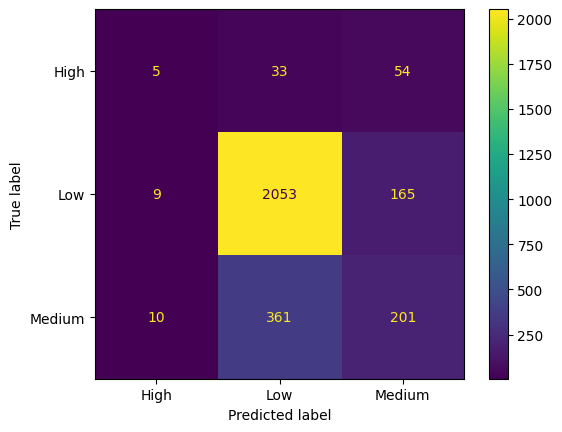

In [20]:
import sklearn.ensemble
modFor = sklearn.ensemble.RandomForestClassifier(random_state = 42)
modFor.fit(featuresTrain, outcomeTrain)
predForTrain = modFor.predict(featuresTrain)
predForTest = modFor.predict(featuresTest)
print(sklearn.metrics.classification_report(outcomeTrain, predForTrain))
print(sklearn.metrics.classification_report(outcomeTest, predForTest))
cmForTest = sklearn.metrics.confusion_matrix(outcomeTest, predForTest)
sklearn.metrics.ConfusionMatrixDisplay(cmForTest, display_labels = modFor.classes_).plot()

Similar to the decision tree, there's clear overfitting here between the training data (100% accurate) and the test data (78% accurate). However, given that the test accuracy is a bit higher here, I would prefer this model vs. the decision tree.

/opt/tljh/user/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/tljh/user/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.00      0.00      0.00       176
         Low       0.81      0.71      0.76      4492
      Medium       0.28      0.45      0.34      1201

    accuracy                           0.64      5869
   macro avg       0.36      0.39      0.37      5869
weighted avg       0.68      0.64      0.65      5869

              precision    recall  f1-score   support

        High       0.00      0.00      0.00        92
         Low       0.81      0.71      0.76      2227
      Medium       0.27      0.44      0.33       572

    accuracy                           0.64      2891
   macro avg       0.36      0.38      0.36      2891
weighted avg       0.68      0.64      0.65      2891



/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.10/site-packages/sklearn/

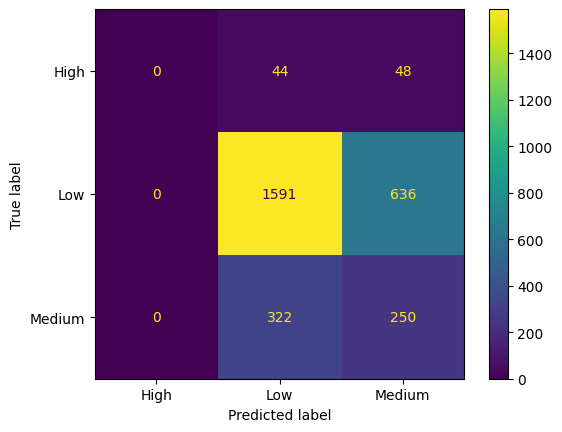

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
featuresTrain_norm = scaler.fit_transform(featuresTrain) #you fit to the training features
featuresTest_norm = scaler.transform(featuresTest)       #you only transform the test features

import sklearn.svm
modSVM = sklearn.svm.SVC(random_state = 42)
modSVM.fit(featuresTrain_norm, outcomeTrain)
predSVMTrain = modFor.predict(featuresTrain_norm)
predSVMTest = modFor.predict(featuresTest_norm)
print(sklearn.metrics.classification_report(outcomeTrain, predSVMTrain))
print(sklearn.metrics.classification_report(outcomeTest, predSVMTest))
cmSVMTest = sklearn.metrics.confusion_matrix(outcomeTest, predSVMTest)
sklearn.metrics.ConfusionMatrixDisplay(cmSVMTest, display_labels = modSVM.classes_).plot()

With the support vector machine, there does not appear to be significant overfitting, as the accuracy is the same between both the training and test data -- 64%. However, the warning messages are printing because, when you look at the classification report and confusion matrix, you can see that the model is not predicting any High outcomes (due to the imbalance in categories). Therefore, given that the overall accuracy is lower than for the Random Forest model and it's not doing a good job of predicting on one of the categories, I don't think this is a good model.

Duplicate this graph:
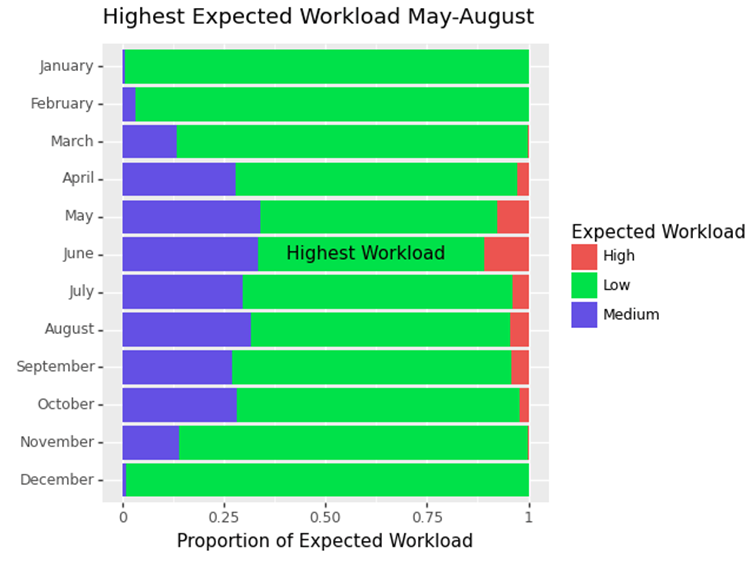

In [22]:
from plotnine import *

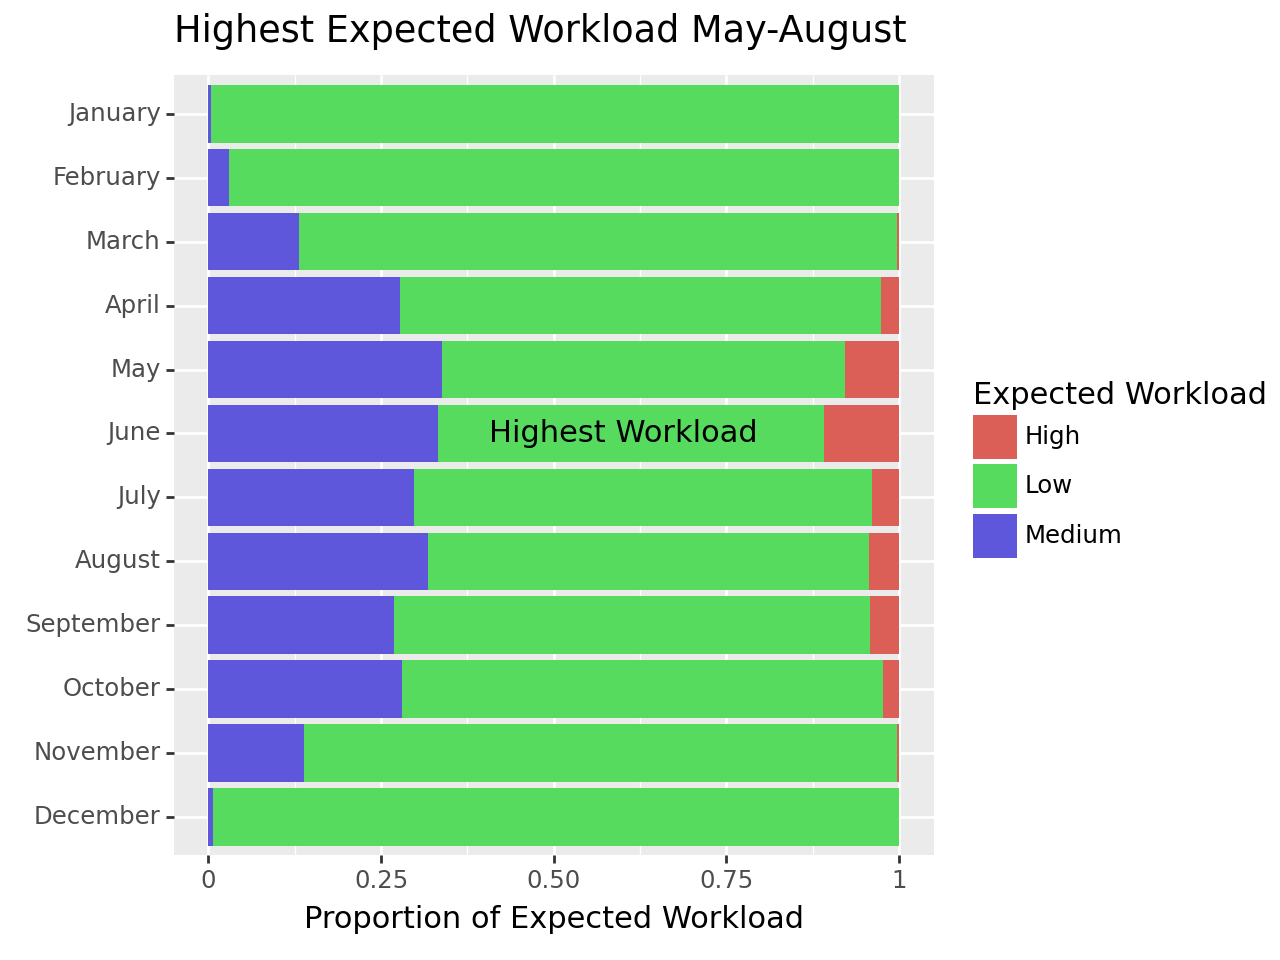

<Figure Size: (640 x 480)>

In [23]:
(ggplot(df, aes(x = "Month", fill = "ExpectedWorkload")) +
   geom_bar(position = "fill") +
   coord_flip() +
   labs(title = "Highest Expected Workload May-August",
       x = "",
       y = "Proportion of Expected Workload", 
       fill = "Expected Workload") +
   scale_x_discrete(limits = ["December", "November", "October", "September",
                             "August", "July", "June", "May",
                             "April", "March", "February", "January"]) +
   annotate("text", label = "Highest Workload", x = "June", y = 0.6))